# 1. Import Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTModel
from sklearn.metrics import f1_score
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Verify GPU availability
print("GPU Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Names:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

2025-05-25 16:22:25.453556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748190145.657849      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748190145.721751      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available: True
Number of GPUs: 2
GPU Names: ['Tesla T4', 'Tesla T4']


 # 2. Configuration

In [2]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 64  # Optimized for T4 GPUs
EPOCHS = 20  # Reduced for speed
DATA_DIR = "/kaggle/input/soil-classification-part-2/soil_competition-2025"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
FEATURES_DIR = "/kaggle/working/features"
os.makedirs(FEATURES_DIR, exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
else:
    print("Using single GPU or CPU")

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

Using 2 GPUs!


# 3. Exploratory Data Analysis (EDA)

## 3.1 Label Distribution

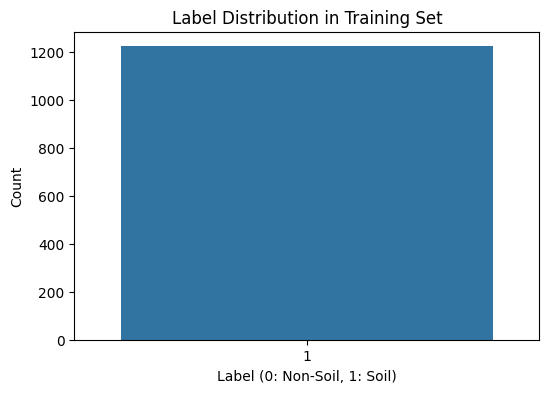

Class counts:
label
1    1222
Name: count, dtype: int64


In [3]:
# Load train_labels.csv
train_labels = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

# Plot label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_labels)
plt.title('Label Distribution in Training Set')
plt.xlabel('Label (0: Non-Soil, 1: Soil)')
plt.ylabel('Count')
plt.show()

# Print class counts
print("Class counts:")
print(train_labels['label'].value_counts())

## 3.2 Image Characteristics

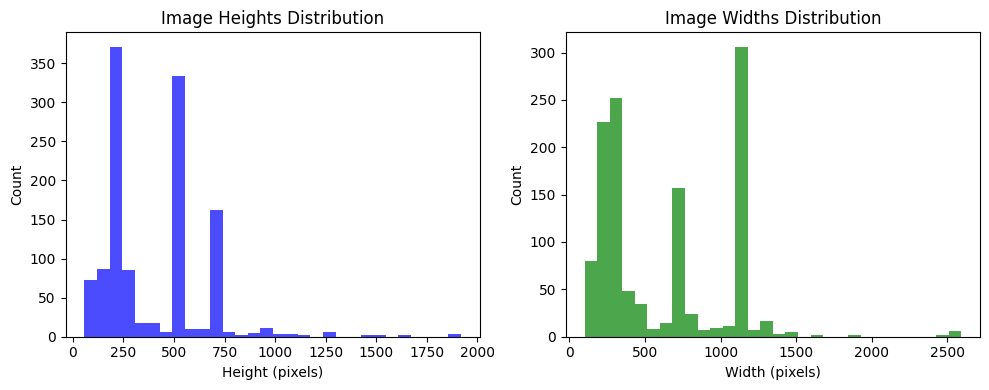

Image formats: .jpg     1116
.jpeg      92
.webp       6
.png        6
.gif        2
Name: count, dtype: int64


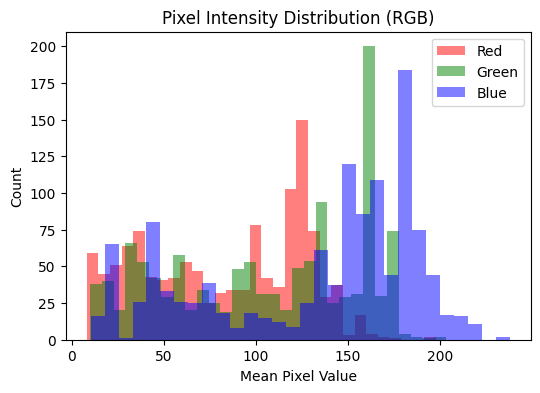

In [4]:
# Function to analyze image properties
def analyze_images(image_dir):
    sizes = []
    formats = []
    pixel_means = []
    
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            sizes.append(img.shape[:2])
            formats.append(os.path.splitext(img_name)[1])
            pixel_means.append(np.mean(img, axis=(0, 1)))
    
    return sizes, formats, pixel_means

# Analyze training images
train_sizes, train_formats, train_pixel_means = analyze_images(TRAIN_DIR)

# Plot image size distribution
heights, widths = zip(*train_sizes)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(heights, bins=30, color='blue', alpha=0.7)
plt.title('Image Heights Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.hist(widths, bins=30, color='green', alpha=0.7)
plt.title('Image Widths Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print format distribution
print("Image formats:", pd.Series(train_formats).value_counts())

# Plot pixel intensity distribution
pixel_means = np.array(train_pixel_means)
plt.figure(figsize=(6, 4))
plt.hist(pixel_means[:, 0], bins=30, color='red', alpha=0.5, label='Red')
plt.hist(pixel_means[:, 1], bins=30, color='green', alpha=0.5, label='Green')
plt.hist(pixel_means[:, 2], bins=30, color='blue', alpha=0.5, label='Blue')
plt.title('Pixel Intensity Distribution (RGB)')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Count')
plt.legend()
plt.show()

## 3.3 Sample Image Visualization

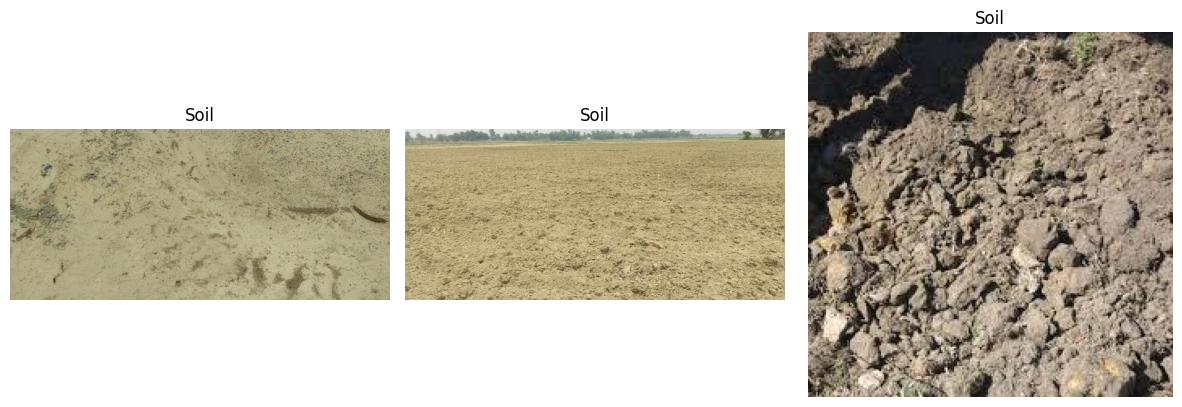

In [5]:
# Visualize sample soil images
soil_images = train_labels[train_labels['label'] == 1]['image_id'].sample(3, random_state=42)

plt.figure(figsize=(12, 4))
for i, img_id in enumerate(soil_images):
    img = cv2.imread(os.path.join(TRAIN_DIR, img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title('Soil')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 4. Data Preprocessing

In [6]:
# Load ViT
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_processor.do_rescale = False
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
if torch.cuda.device_count() > 1:
    vit_model = nn.DataParallel(vit_model)

# Load image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

# Custom Dataset
class SoilDataset(Dataset):
    def __init__(self, image_paths, labels=None):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = load_image(self.image_paths[idx])
        img = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return img, label
        return img

# Precompute ViT features
def precompute_vit_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading precomputed features from {output_file}")
        with h5py.File(output_file, 'r') as f:
            features = f['features'][:]
        return features

    dataset = SoilDataset(image_paths)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    features = []
    
    vit_model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            inputs = image_processor(images=batch, return_tensors="pt", do_rescale=False)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = vit_model(**inputs).last_hidden_state[:, 0, :].cpu().numpy()
            features.append(outputs)
    
    features = np.concatenate(features, axis=0)
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('features', data=features)
    print(f"Saved features to {output_file}")
    return features

# Load dataset
train_labels = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))
test_ids = pd.read_csv(os.path.join(DATA_DIR, "test_ids.csv"))
train_image_paths = [os.path.join(TRAIN_DIR, img_id) for img_id in train_labels['image_id']]
train_labels_array = train_labels['label'].values
test_image_paths = [os.path.join(TEST_DIR, img_id) for img_id in test_ids['image_id']]

# Precompute features
train_features_file = os.path.join(FEATURES_DIR, "train_features.h5")
test_features_file = os.path.join(FEATURES_DIR, "test_features.h5")
train_features = precompute_vit_features(train_image_paths, train_features_file, BATCH_SIZE)
test_features = precompute_vit_features(test_image_paths, test_features_file, BATCH_SIZE)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Saved features to /kaggle/working/features/train_features.h5
Saved features to /kaggle/working/features/test_features.h5


# 5. Model Definition

In [7]:
class SoilAutoencoder(nn.Module):
    def __init__(self):
        super(SoilAutoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Linear(768, 512)
        self.enc2 = nn.Linear(512, 256)
        self.enc3 = nn.Linear(256, 128)
        # Decoder
        self.dec1 = nn.Linear(128, 256)
        self.dec2 = nn.Linear(256, 512)
        self.dec3 = nn.Linear(512, 768)
        
    def forward(self, x):
        # Encode
        x = torch.relu(self.enc1(x))
        x = torch.relu(self.enc2(x))
        x = torch.relu(self.enc3(x))
        # Decode
        x = torch.relu(self.dec1(x))
        x = torch.relu(self.dec2(x))
        x = self.dec3(x)  # No activation for output
        return x

# 6. Training Autoencoder

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return F.linear(input, self.weight, self.bias)


Epoch 1/20, Train Loss: 0.028203, Val Loss: 0.025777, Pseudo-F1: 0.9462
Epoch 2/20, Train Loss: 0.023497, Val Loss: 0.021477, Pseudo-F1: 0.9462
Epoch 3/20, Train Loss: 0.020628, Val Loss: 0.018365, Pseudo-F1: 0.9462
Epoch 4/20, Train Loss: 0.017845, Val Loss: 0.016903, Pseudo-F1: 0.9462
Epoch 5/20, Train Loss: 0.016386, Val Loss: 0.015632, Pseudo-F1: 0.9462
Epoch 6/20, Train Loss: 0.015127, Val Loss: 0.014768, Pseudo-F1: 0.9462
Epoch 7/20, Train Loss: 0.014237, Val Loss: 0.013980, Pseudo-F1: 0.9462
Epoch 8/20, Train Loss: 0.013130, Val Loss: 0.013438, Pseudo-F1: 0.9462
Epoch 9/20, Train Loss: 0.012646, Val Loss: 0.012875, Pseudo-F1: 0.9462
Epoch 10/20, Train Loss: 0.011985, Val Loss: 0.012377, Pseudo-F1: 0.9485
Epoch 11/20, Train Loss: 0.011362, Val Loss: 0.011870, Pseudo-F1: 0.9462
Epoch 12/20, Train Loss: 0.010816, Val Loss: 0.011508, Pseudo-F1: 0.9462
Epoch 13/20, Train Loss: 0.010469, Val Loss: 0.011225, Pseudo-F1: 0.9462
Epoch 14/20, Train Loss: 0.009865, Val Loss: 0.010806, Pseud

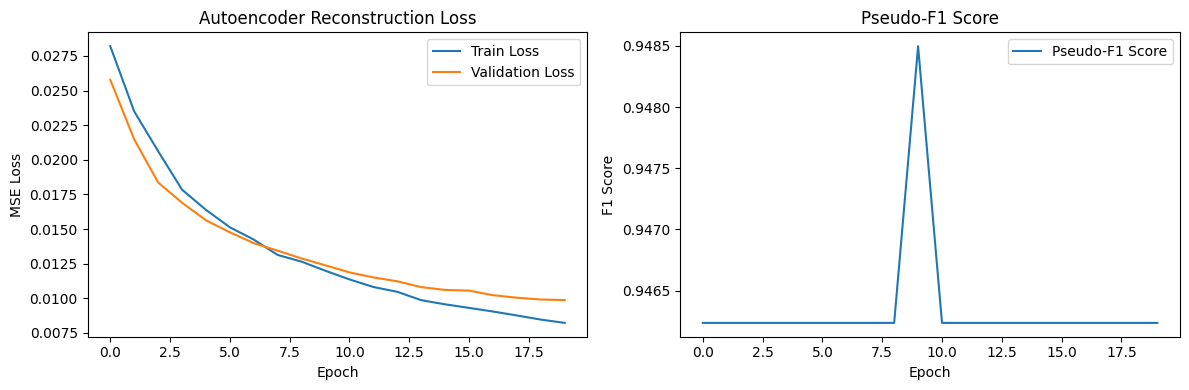

In [8]:
# Custom Dataset for features
class FeatureDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32)

# Training function with pseudo-F1-score
def train_autoencoder(model, train_loader, val_loader, epochs=20, device=device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add weight decay
    best_val_loss = float('inf')
    best_model_state = None
    train_losses, val_losses, val_f1_scores = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for features in train_loader:
            features = features.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, features)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        val_errors = []
        with torch.no_grad():
            for features in val_loader:
                features = features.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, features).item()
                errors = torch.mean((outputs - features) ** 2, dim=1).cpu().numpy()
                val_errors.extend(errors)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Compute pseudo-F1-score
        val_errors = np.array(val_errors)
        threshold = np.percentile(val_errors, 90)  # Top 10% errors as pseudo-non-soil
        pseudo_preds = (val_errors <= threshold).astype(int)  # Low error = soil (1)
        true_labels = np.ones(len(val_errors))  # All validation images are soil
        val_f1 = f1_score(true_labels, pseudo_preds, zero_division=0)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Pseudo-F1: {val_f1:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    return best_model_state, train_losses, val_losses, val_f1_scores

# 80-20 split for validation
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(range(len(train_features)), test_size=0.2, random_state=42)
train_features_split = train_features[train_idx]
val_features_split = train_features[val_idx]

# Create datasets and loaders
train_dataset = FeatureDataset(train_features_split)
val_dataset = FeatureDataset(val_features_split)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Train autoencoder
model = SoilAutoencoder().to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
best_model_state, train_losses, val_losses, val_f1_scores = train_autoencoder(model, train_loader, val_loader, EPOCHS, device)
model.load_state_dict(best_model_state)

# Plot losses and F1-scores
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Autoencoder Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Pseudo-F1 Score')
plt.title('Pseudo-F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Anomaly Detection and Submission

In [9]:
# Compute reconstruction errors on validation set
model.eval()
val_errors = []
with torch.no_grad():
    for features in val_loader:
        features = features.to(device)
        outputs = model(features)
        errors = torch.mean((outputs - features) ** 2, dim=1).cpu().numpy()
        val_errors.extend(errors)
val_errors = np.array(val_errors)

# Set threshold
threshold = np.mean(val_errors) + 2 * np.std(val_errors)
print(f"Reconstruction error threshold: {threshold:.6f}")

# Predict on test set
test_dataset = FeatureDataset(test_features)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_errors = []
with torch.no_grad():
    for features in test_loader:
        features = features.to(device)
        outputs = model(features)
        errors = torch.mean((outputs - features) ** 2, dim=1).cpu().numpy()
        test_errors.extend(errors)
test_preds = (np.array(test_errors) > threshold).astype(int)  # High error = non-soil (0)

# Create submission
submission = pd.DataFrame({'image_id': test_ids['image_id'], 'label': 1 - test_preds})  # Invert: high error = 0
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file created: /kaggle/working/submission.csv")

Reconstruction error threshold: 0.023620
Submission file created: /kaggle/working/submission.csv
